# Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle


# Set Global Variables

In [ ]:
language = 'asl'
PARENT_FOLDER = '/content/drive/MyDrive/sign-language/{}/'.format(language)
DESTINATION_FOLDER = '/content/drive/MyDrive/sign-language/split/{}'.format(language)


OUTPUT_PATH = '/content/drive/MyDrive/sign-language/model/'
MODEL_PATH = os.path.join(OUTPUT_PATH, '{}_bestResNet101.keras'.format(language))
HISTORY_PATH = os.path.join(OUTPUT_PATH, '{}_bestResNet101.pkl'.format(language))


BATCH_SIZE = 32
EPOCHS = 15
TRAIN_DIR = os.path.join(DESTINATION_FOLDER, 'train')
TEST_DIR = os.path.join(DESTINATION_FOLDER, 'test')

# Data augmentation and normalization

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define image parameters
img_width, img_height = 100, 100
input_shape = (img_width, img_height, 3)


# Generate batches of augmented training and testing data

In [ ]:
# Prepare training and testing data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2120 images belonging to 36 classes.
Found 395 images belonging to 36 classes.


# Define a ResNet101 base model with pre-trained ImageNet weights

In [ ]:
resent_model = ResNet101(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the layers
for layer in resent_model.layers:
    layer.trainable = False

model = Sequential([
    resent_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(36, activation='softmax')
])


171446536/171446536 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 36)                18468     
                                                                 
Total params: 59454372 (226.80 MB)
Trainable params: 16796196 (64.07 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


# Training the model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True,
                                                save_weights_only=False, mode='max')

# Train the model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=[checkpoint])


Epoch 1/15
67/67 [==============================] - 652s 10s/step - loss: 4.7395 - accuracy: 0.0788 - val_loss: 3.3284 - val_accuracy: 0.1038
Epoch 2/15
67/67 [==============================] - 244s 4s/step - loss: 3.2123 - accuracy: 0.1193 - val_loss: 2.9107 - val_accuracy: 0.1570
Epoch 3/15
67/67 [==============================] - 260s 4s/step - loss: 2.7969 - accuracy: 0.1679 - val_loss: 2.4427 - val_accuracy: 0.2253
Epoch 4/15
67/67 [==============================] - 253s 4s/step - loss: 2.4655 - accuracy: 0.2278 - val_loss: 2.1889 - val_accuracy: 0.3038
Epoch 5/15
67/67 [==============================] - 256s 4s/step - loss: 2.2468 - accuracy: 0.2873 - val_loss: 1.9878 - val_accuracy: 0.3392
Epoch 6/15
67/67 [==============================] - 254s 4s/step - loss: 2.0607 - accuracy: 0.3340 - val_loss: 1.7275 - val_accuracy: 0.4354
Epoch 7/15
67/67 [==============================] - 250s 4s/step - loss: 1.9245 - accuracy: 0.3665 - val_loss: 1.6195 - val_accuracy: 0.4684
Epoch 8/15
6

In [ ]:
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
best_model = tf.keras.models.load_model(MODEL_PATH)

loss, accuracy = best_model.evaluate(test_generator)
print('Testing Accuracy: {}'.format(accuracy))

13/13 [==============================] - 40s 3s/step - loss: 1.0698 - accuracy: 0.6532
Testing Accuracy: 0.6531645655632019


# Results of training phase

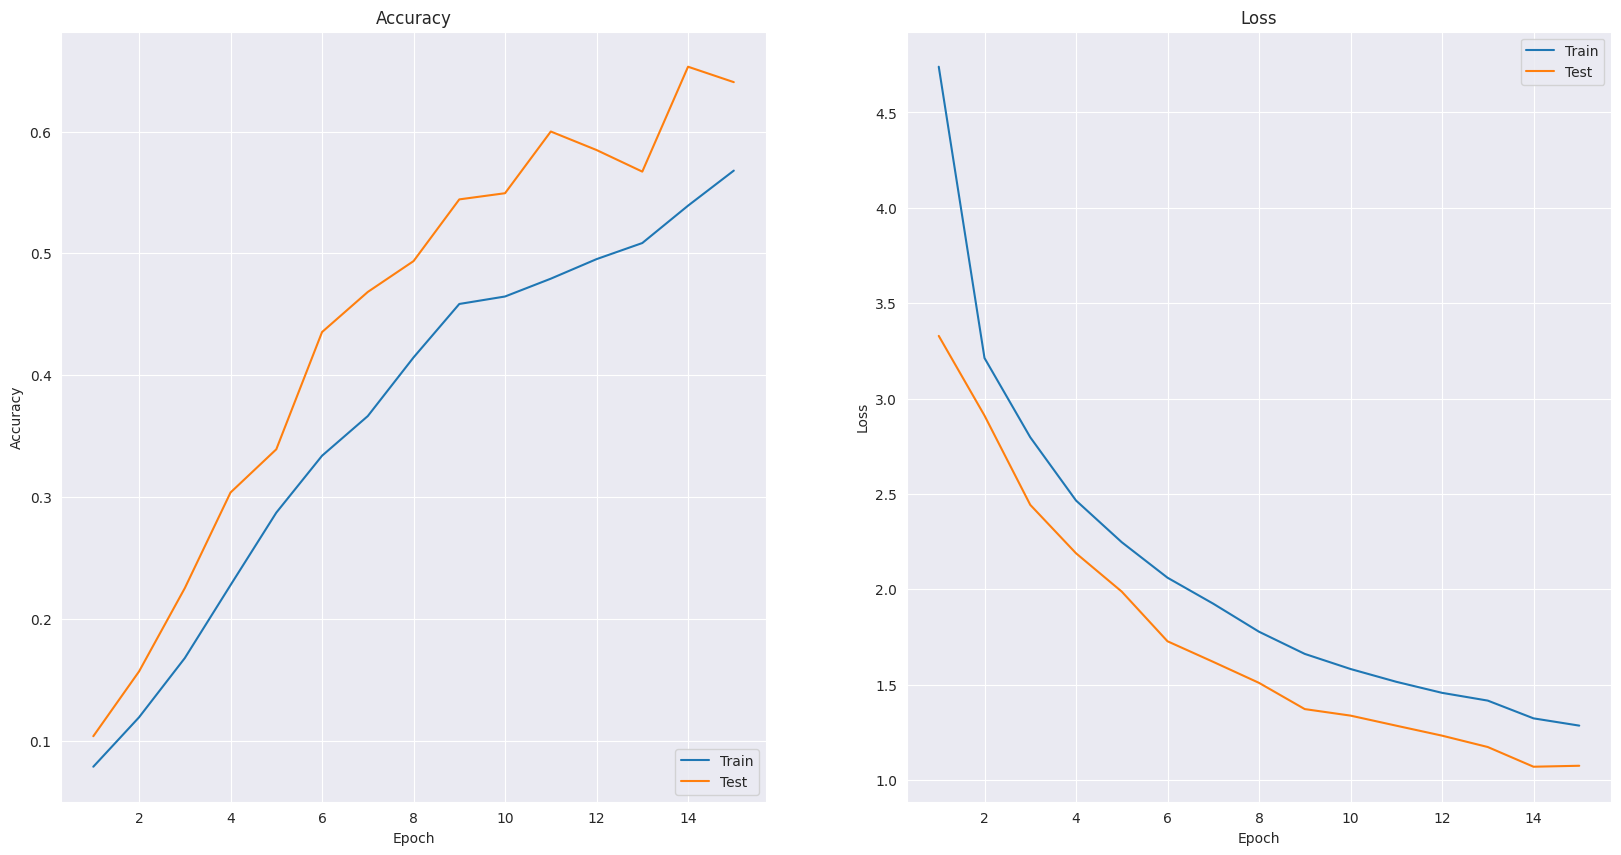

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize=(20, 10))

x = [i+1 for i in range(15)]

plt.subplot(1, 2, 1)
sns.lineplot(x=x, y=history.history['accuracy'], label='Train')
sns.lineplot(x=x, y=history.history['val_accuracy'], label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
sns.lineplot(x=x, y=history.history['loss'], label='Train')
sns.lineplot(x=x, y=history.history['val_loss'], label='Test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.savefig(os.path.join(OUTPUT_PATH, '{}_ResNet101.png'.format(language)))
plt.show()

# Confusion Matrix

13/13 [==============================] - 35s 2s/step


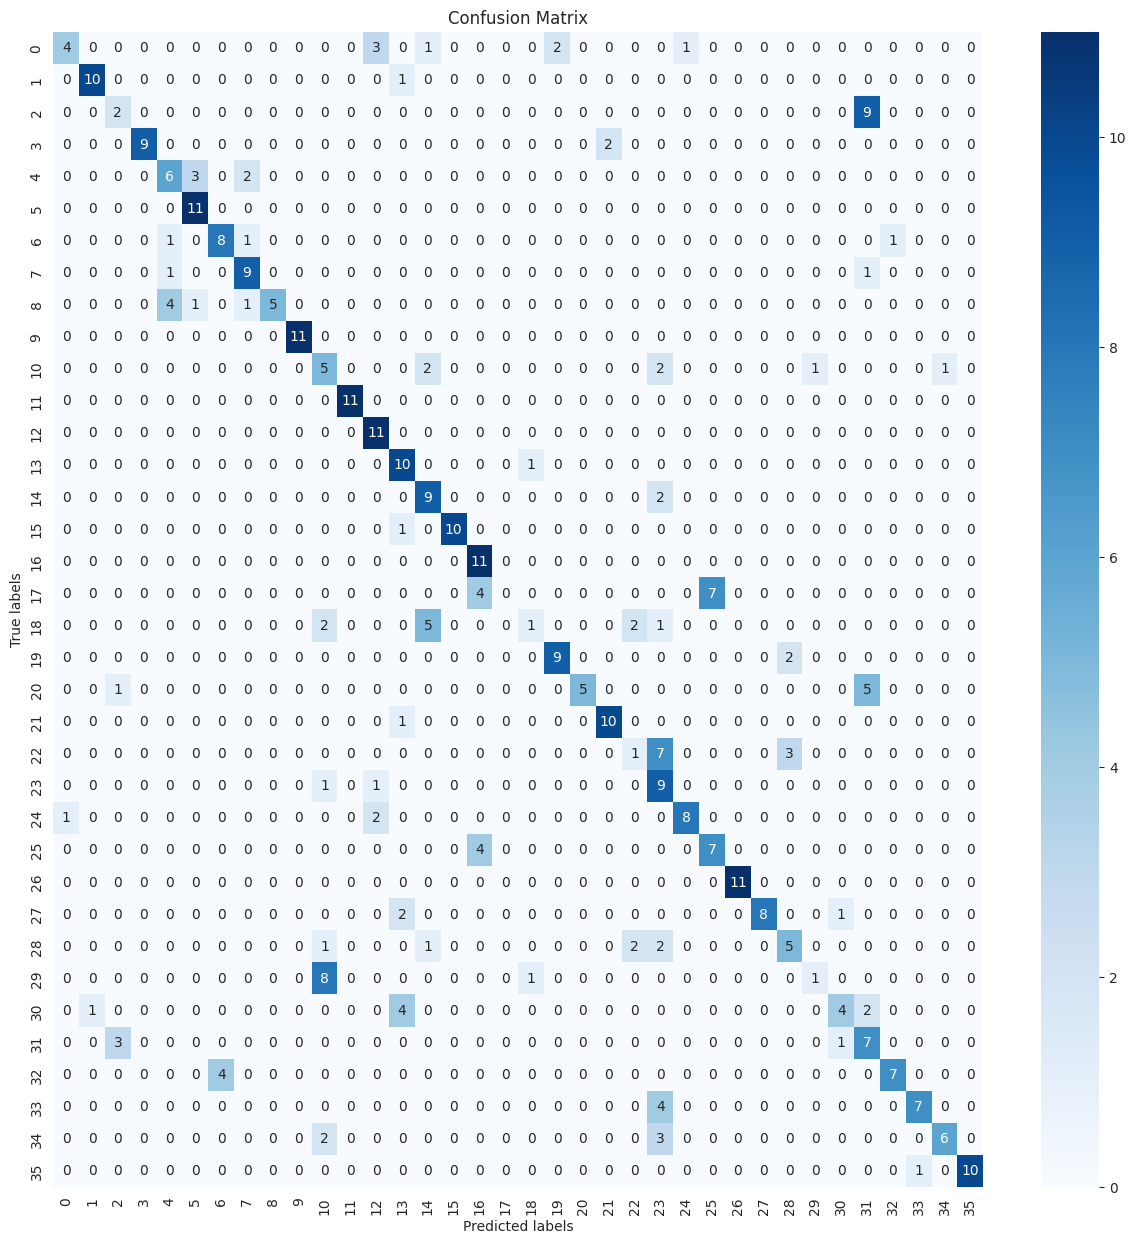

In [ ]:

test_images = []
test_labels = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    test_images.extend(batch[0])
    test_labels.extend(np.argmax(batch[1], axis=1))

test_images = np.array(test_images)
test_labels = np.array(test_labels)
predictions = np.argmax(best_model.predict(test_images), axis=1)

cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(15, 15))
labels = os.listdir(TEST_DIR)
labels.sort()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_PATH, '{}_ResNet101_conf.png'.format(language)))
plt.show()